In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
# to share the GPU resources for multiple sessions
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

%matplotlib inline

2023-11-07 14:15:09.523249: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 14:15:09.576874: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GRID A100D-80C, pci bus id: 0000:02:02.0, compute capability: 8.0



2023-11-07 14:15:11.212437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 14:15:11.219387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 14:15:11.219552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

**Dataset Download Link**
[https://drive.google.com/file/d/1ULKLK_R0qsLho6PzfUIOwTXOStk3w5jd/view?usp=sharing](https://drive.google.com/file/d/1ULKLK_R0qsLho6PzfUIOwTXOStk3w5jd/view?usp=sharing)

In [ ]:
# Upload this file to your google drive

In [ ]:
# for Google Colab
drive.mount('/content/drive')

In [ ]:
# for Google Colab
!tar --skip-old-files -xvf '/content/drive/MyDrive/Dataset/cell_images.tar.xz' -C '/content/drive/MyDrive/Dataset/'

In [ ]:
# for Google Colab
my_data_dir = '/content/drive/MyDrive/Dataset/cell_images'

In [9]:
# for college server
my_data_dir = 'dataset/cell_images'

In [10]:
os.listdir(my_data_dir)

['test', 'train']

In [11]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [12]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [14]:
len(os.listdir(train_path+'/uninfected/'))

12479

In [15]:
len(os.listdir(train_path+'/parasitized/'))

12479

In [16]:
os.listdir(train_path+'/parasitized')[0]

'C182P143NThinF_IMG_20151201_172257_cell_157.png'

In [17]:
para_img= imread(train_path+
                 '/parasitized/'+
                 os.listdir(train_path+'/parasitized')[0])

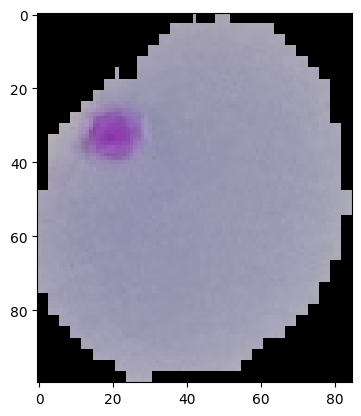

In [18]:
plt.imshow(para_img)

In [19]:
# Checking the image dimensions
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

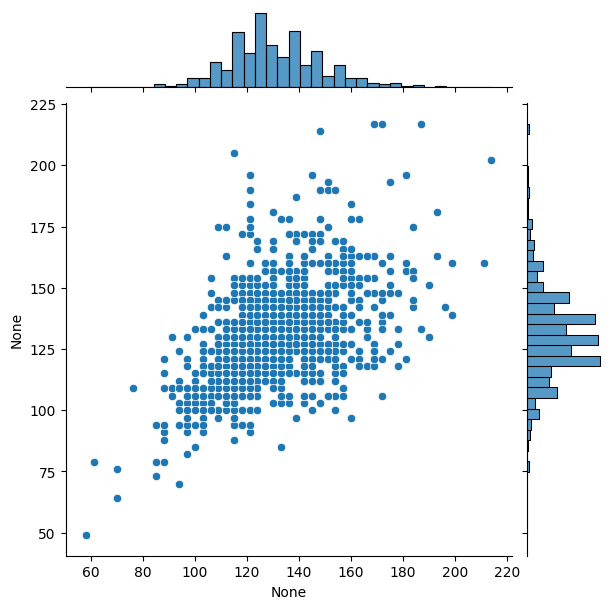

In [20]:
sns.jointplot(x=dim1,y=dim2)

In [21]:
image_shape = (130,130,3)

In [22]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more infor

In [23]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [24]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [25]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [27]:
model = models.Sequential([
    layers.Input((130, 130, 3)),
    layers.Conv2D(32, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(32, kernel_size=3, activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(32, kernel_size=3, activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", metrics='accuracy', optimizer="adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 130, 130, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 65, 65, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)       

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 130, 130, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 65, 65, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)       

In [29]:
batch_size = 16

In [30]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras.src.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.src.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Args:
        directory: string, path to the target directory. It should contain
          one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
          inside each of the subdirectories directory tree will be included
          in the generator. See [this script](
          https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
          for more details.
        target_size: Tuple of integers `(height, width)`, defaults to `(256,
          256)`. The di

In [31]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [32]:
train_image_gen.batch_size

16

In [33]:
len(train_image_gen.classes)

24958

In [34]:
train_image_gen.total_batches_seen

0

In [35]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [36]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [37]:
results = model.fit(train_image_gen,epochs=20,
                              validation_data=test_image_gen
                             )

Epoch 1/20


2023-11-07 14:17:57.837499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-11-07 14:17:58.087967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-07 14:17:58.148247: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc3a17a41c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 14:17:58.148285: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GRID A100D-80C, Compute Capability 8.0
2023-11-07 14:17:58.154060: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-07 14:17:58.287561: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1560/1560 [==============================] - 109s 69ms/step - loss: 0.5810 - accuracy: 0.6355 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
1560/1560 [==============================] - 106s 68ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
1560/1560 [==============================] - 107s 68ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/20
1560/1560 [==============================] - 107s 69ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
1560/1560 [==============================] - 107s 68ms/step - loss: 0.4184 - accuracy: 0.7592 - val_loss: 0.2014 - val_accuracy: 0.9200
Epoch 6/20
1560/1560 [==============================] - 107s 69ms/step - loss: 0.1859 - accuracy: 0.9377 - val_loss: 0.1892 - val_accuracy: 0.9342
Epoch 7/20
1560/1560 [==============================] - 107s 69ms/step - loss: 0.1658 - accuracy: 0.9466 - val_loss: 0.1905 - val

In [38]:
model.save('cell_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
losses = pd.DataFrame(model.history.history)

<Axes: >

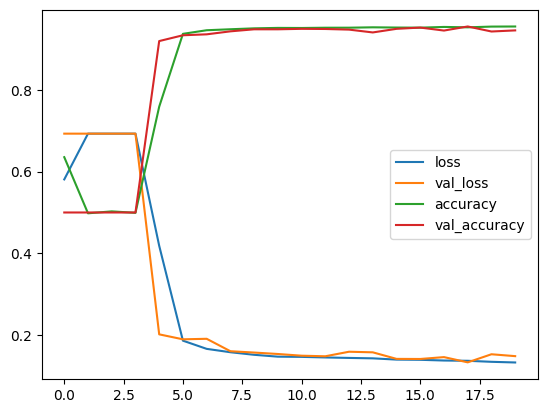

In [48]:
losses[['loss','val_loss','accuracy','val_accuracy']].plot()

<Axes: >

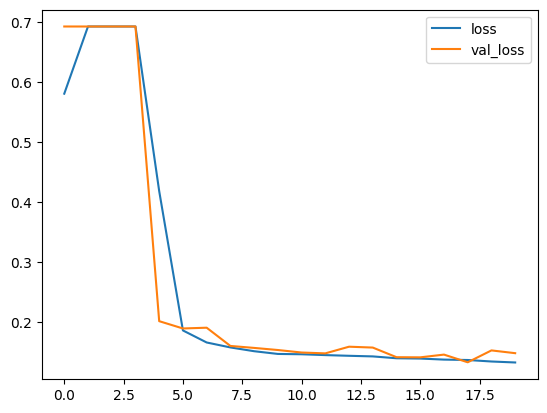

In [40]:
losses[['loss','val_loss']].plot()

In [41]:
model.metrics_names

['loss', 'accuracy']

In [42]:
model.evaluate(test_image_gen)

163/163 [==============================] - 10s 63ms/step - loss: 0.1495 - accuracy: 0.9488


[0.14949044585227966, 0.948846161365509]

In [43]:
pred_probabilities = model.predict(test_image_gen)

163/163 [==============================] - 10s 62ms/step


In [44]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [45]:
predictions = pred_probabilities > 0.5

In [46]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1300
           1       0.94      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [47]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1225,   75],
       [  44, 1256]])